# Here I intend to create a model to predict when a client will accept a term deposit.

1- Exploratory Data Analysis  
2- Preprocessing  
3- KNN  
4- SVM  
5- Random Forest  
6- Boosting  
7- Brief talk about other metrics  
8- Interpretability  

In [3]:
#importing libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

from sklearn.metrics import confusion_matrix, classification_report

from pdpbox import pdp, get_dataset, info_plots
import shap

from yellowbrick.classifier import ROCAUC
from yellowbrick.classifier import PrecisionRecallCurve
from yellowbrick.model_selection import LearningCurve, ValidationCurve, learning_curve


import warnings
warnings.filterwarnings(action="ignore")

# 1- Exploratory Data Analysis
### Time to know the data. Time to get insights, to look distributions and relationship among variables and to identify potential problems like missing values, outliers and errors. After some informations about the dataset, I am going to make important checkings, the partition into train/test and some plots.

## Knowing the dataset
#### According to documentation, this is the classic marketing bank dataset uploaded originally in the UCI Machine Learning Repository.

## Source:
[Moro et al., 2014] S. Moro, P. Cortez and P. Rita. A Data-Driven Approach to Predict the Success of Bank Telemarketing. Decision Support Systems, Elsevier, 62:22-31, June 2014

## Attribute Information:
### About client features:
-age  
-job (type of job)  
-marital (marital status)  
-education  
-default (has credit in default? 'no','yes','unknown')  
-balance  
-housing (has housing loan?'no','yes','unknown')  
-loan (has personal loan?'no','yes','unknown')   
  
## About current campaign:
-contact (communication type: 'cellular','telephone')  
-duration (last contact duration, in seconds) Important note: the duration attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.  
-day (last contact day of the week)  
-month (last contact month of year)  
-campaign (number of contacts performed during this campaign and for this client)  
-deposit (has the client subscribed a term deposit?'yes','no')  

In [4]:
df = pd.read_csv(r'C:\Users\TariK\Classification-Bank Marketing Dataset\bank.csv')
print(df.shape)

(11162, 17)


## Some checkings

In [5]:
#checking for duplicated rows and missing values
print(df.duplicated().sum())
print(df.isnull().sum().sum())

0
0


In [6]:
#checking types
df.dtypes.sort_values()

age           int64
previous      int64
pdays         int64
campaign      int64
duration      int64
balance       int64
day           int64
month        object
contact      object
loan         object
housing      object
default      object
education    object
marital      object
job          object
poutcome     object
deposit      object
dtype: object

In [7]:
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000
mean,41.231948,1528.538524,15.658036,371.993818,2.508421,51.330407,0.832557
std,11.913369,3225.413326,8.420740,347.128386,2.722077,108.758282,2.292007
min,18.000000,-6847.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,122.000000,8.000000,138.000000,1.000000,-1.000000,0.000000
50%,39.000000,550.000000,15.000000,255.000000,2.000000,-1.000000,0.000000
75%,49.000000,1708.000000,22.000000,496.000000,3.000000,20.750000,1.000000
max,95.000000,81204.000000,31.000000,3881.000000,63.000000,854.000000,58.000000


In [8]:
for col in df.select_dtypes(include='object').columns:
    print(col)
    print(df[col].unique())

job
['admin.' 'technician' 'services' 'management' 'retired' 'blue-collar'
 'unemployed' 'entrepreneur' 'housemaid' 'unknown' 'self-employed'
 'student']
marital
['married' 'single' 'divorced']
education
['secondary' 'tertiary' 'primary' 'unknown']
default
['no' 'yes']
housing
['yes' 'no']
loan
['no' 'yes']
contact
['unknown' 'cellular' 'telephone']
month
['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'jan' 'feb' 'mar' 'apr' 'sep']
poutcome
['unknown' 'other' 'failure' 'success']
deposit
['yes' 'no']


In [9]:
df.drop("duration",axis=1, inplace=True)

In [10]:
#checking class deposit
df.deposit.value_counts()/df.deposit.count()

no     0.52616
yes    0.47384
Name: deposit, dtype: float64

# Partitioning, creating a Test Set

In [11]:
#I'm going to use StratifiedShuffleSplit to preserve the class proportions.

sss=StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=1)
for train_index, test_index in sss.split(df.drop("deposit",axis=1), df.deposit):
    traindf=df.loc[train_index] #to select only rows (with all columns) we dont need comma and colon.
    testdf= df.loc[test_index]

## Plots

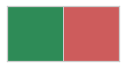

In [12]:
# setting my own palette
mypalette = ['seagreen', 'indianred']
sns.set_palette(mypalette)
sns.palplot(sns.color_palette())

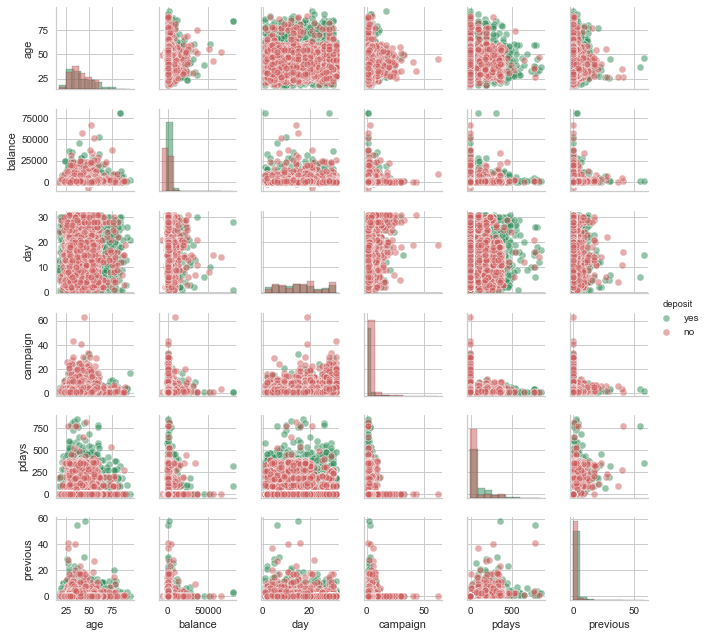

In [13]:
# Scatterplots to search for linear and non-linear relationships and histograms.
sns.pairplot(traindf, diag_kind='hist',  hue= 'deposit', height=1.5, 
             diag_kws={"edgecolor":"k", "alpha":0.5},
             plot_kws={"alpha":0.5})

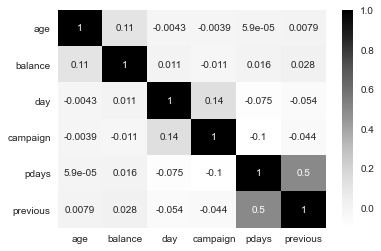

In [14]:
#Pearson’s Correlations, which measures the strength of a linear relationship
sns.heatmap(traindf.corr(method='pearson'), cmap="Greys", annot=True)

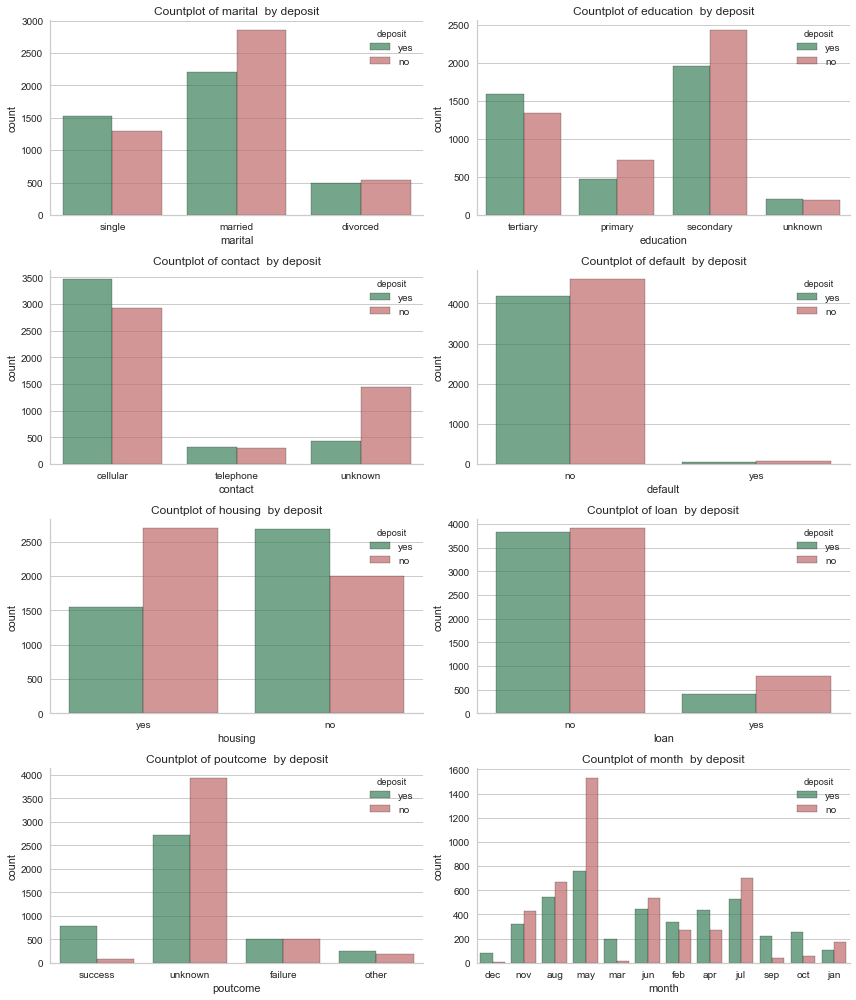

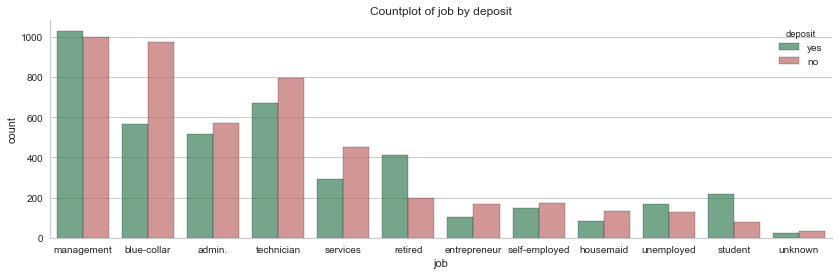

In [15]:
#barplots showing the frequency of each category separated by label
plt.figure(figsize=[12,14])
features=["marital", "education", "contact", "default", "housing", "loan", "poutcome", "month"]
n=1
for f in features:
    plt.subplot(4,2,n)
    sns.countplot(x=f, hue='deposit', edgecolor="black", alpha=0.7, data=traindf)
    sns.despine()
    plt.title("Countplot of {}  by deposit".format(f))
    n=n+1
plt.tight_layout()
plt.show()


    
plt.figure(figsize=[14,4])
sns.countplot(x='job', hue='deposit',edgecolor="black", alpha=0.7, data=traindf)
sns.despine()
plt.title("Countplot of job by deposit")
plt.show()

# 2- Preprocessing

In [16]:
#encoding target label
LE=LabelEncoder()
df['deposit']=LE.fit_transform(df.deposit.values)

#encoding categorical features
df=pd.get_dummies(df)

In [17]:
#partitioning again
for train_index, test_index in sss.split(df.drop("deposit",axis=1), df.deposit):
    traindf=df.loc[train_index]
    testdf= df.loc[test_index]

In [18]:
#partition x/y
xtrain=traindf.drop('deposit', axis=1)
ytrain=traindf.deposit

xtest=testdf.drop('deposit', axis=1)
ytest=testdf.deposit

**Next topics will be about models, be aware that when the model works well on training but not on testing, this can indicates overfitting (high variance). The model is not generalizing well on unseen data, and it can be learning a pattern from the noise. It can be solved making the model simpler tuning the complexity (regularization) for example.**

# 3 - KNN

**K-nearest neighbor is an instance-based and nonparametric algorithm. Nonparametric because it doesn't have a determinated number of parameters before training and instance based because it memorizes the training dataset. It's also considered a lazy learning due to this learning process.**

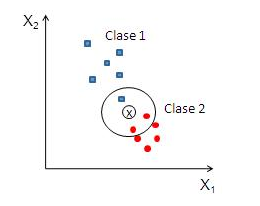

**KNN works to find the K-nearest neighbors of a new sample, based on a distance metric (usually Euclidean distance), and make the prediction. In classification problem, the new point can be classified based on majority vote and in regression problems the prediction can be based on average of k-neighbors.**  

**The choose of K parameter is important because small k can lead to overfitting.**

In [19]:
# pipeline combining transformers and estimator
pipe_knn= make_pipeline(StandardScaler(), KNeighborsClassifier())
 
# grid searh to choose the best (combination of) hyperparameters
gs_knn=GridSearchCV(estimator= pipe_knn,
               param_grid={'kneighborsclassifier__n_neighbors':[4,5,6,7]},
               scoring='accuracy',
               cv=10)

# nested cross validation combining grid search (inner loop) and k-fold cv (outter loop)
gs_knn_scores = cross_val_score(gs_knn, X=xtrain, y=ytrain, cv=5,scoring='accuracy', n_jobs=-1)

# fit, and fit with best estimator
gs_knn.fit(xtrain, ytrain)
gs_knn_best=gs_knn.best_estimator_
gs_knn_best.fit(xtrain, ytrain)

print('Train Accuracy:   {0:.1f}%'.format(gs_knn.score(xtrain, ytrain)*100))
print('CV Mean Accuracy: {0:.1f}%'.format(np.mean(gs_knn_scores)*100))
print('Test Accuracy:    {0:.1f}%'.format(gs_knn.score(xtest, ytest)*100))

Train Accuracy:   76.0%
CV Mean Accuracy: 68.8%
Test Accuracy:    68.5%


# 4 - SVM

**Support Vector Machine (SVM) can be used for classification, regression and even outlier detection.**  

**SVM works to find the hyperplane (decision boundary) that best separates training data. There are many ways of separating them but the best way is that one that maximizes the distance between hyperplane and the points closest to it. Like the red one on the graph. All this to avoid misclassification of a new instance.**  

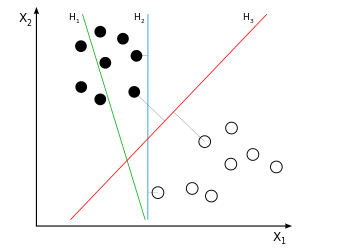

**The points closest to the hyperplane are called support vectors.**  

**What if it's not linearly separable? SVM can map the problem on a higher dimensional space, where it can be linearly separable. These methods are called kernel methods and Radial Basis Function (RBF) is an example of them.**  

**What about hyperparameters?** 

**C can control the penalty for misclassification and can help avoiding overfitting.**  

**Larger C, more penalty, tighter margin, less misclassification on training, more variance.**  
**Smaller C, less penalty, larger margin, more misclassification on training,less variance.**  

**In case of a problem considered nonlinear, we have the gamma hyperparameter, which will control the importance of training points and can also help avoiding overfitting. Less gamma, softer decision boundary. Higher gamma, more "fitted" to training points and more likely to overfitting.**

In [20]:
# pipeline combining transformers and estimator
pipe_svm= make_pipeline(StandardScaler(), SVC(random_state=1))

# grid searh to choose the best (combination of) hyperparameters
r=[0.1,1,10]
pg_svm=[{'svc__C':r, 'svc__kernel':['linear']},
        {'svc__C':r, 'svc__gamma':r, 'svc__kernel':['rbf']}]

gs_svm=GridSearchCV(estimator= pipe_svm,
               param_grid= pg_svm,
               scoring='accuracy',
               cv=2)

# nested cross validation combining grid search (inner loop) and k-fold cv (outter loop)
gs_svm_scores = cross_val_score(gs_svm, X=xtrain, y=ytrain, cv=5,scoring='accuracy', n_jobs=-1)

# fit, and fit with best estimator
gs_svm.fit(xtrain, ytrain)
gs_svm_best=gs_svm.best_estimator_
gs_svm_best.fit(xtrain, ytrain)

print('Train Accuracy:   {0:.1f}%'.format(gs_svm.score(xtrain, ytrain)*100))
print('CV Mean Accuracy: {0:.1f}%'.format(np.mean(gs_svm_scores)*100))
print('Test Accuracy:    {0:.1f}%'.format(gs_svm.score(xtest, ytest)*100))

Train Accuracy:   85.3%
CV Mean Accuracy: 69.4%
Test Accuracy:    68.7%


# 5 - Random Forest

**Before Random Forest, let's remind something about Decision Trees. Roughly speaking, Decicion Trees split data making questions about feature values at each node. During this split there is the goal of maximizing the information gain at each split. Information gain can be understood as the difference between the impurity of a parent node and the sum of impurities of its child nodes. Thus, less impurity on child nodes, more information gain.**  

**Random Forest is an ensemble of decision trees. Ensemble is a method that combines many models. The final prediction can be, for example, the average of them (regression) or the majority votes (classification). Random Forest consists in a group of decision trees built on samples of training dataset. More specifically, what happens is a sampling with replacement (bootstrap sampling, bagging ensemble method).**

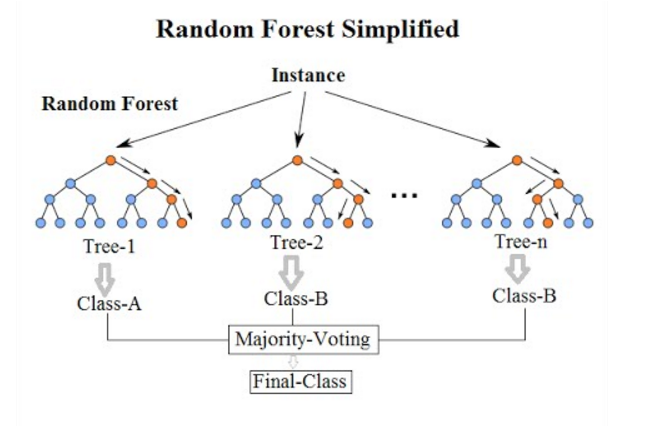

**But why "random"? Because at each split, instead of choosing the feature that maximize de information gain among all features, will be considered only a random subset of the features. This brings some diversity to the model.**  

**Random Forest is easy, robust and can collaborate with interpretability. Some of the advantages of Random Forest are the possibility of check feature importance.**  

In [21]:
rf= RandomForestClassifier(random_state=1)

# grid searh to choose the best (combination of) hyperparameters
pg_rf={'n_estimators': [100,200,400],'max_depth': [20,40,60]}

gs_rf=GridSearchCV(estimator= rf,
               param_grid= pg_rf,
               scoring='accuracy',
               cv=2)

# nested cross validation combining grid search (inner loop) and k-fold cv (outter loop)
gs_rf_scores = cross_val_score(gs_rf, X=xtrain, y=ytrain, cv=5,scoring='accuracy', n_jobs=-1)

# fit, and fit with best estimator
gs_rf.fit(xtrain, ytrain)
gs_rf_best=gs_rf.best_estimator_
gs_rf_best.fit(xtrain, ytrain)

print('Train Accuracy:   {0:.1f}%'.format(gs_rf.score(xtrain, ytrain)*100))
print('CV Mean Accuracy: {0:.1f}%'.format(np.mean(gs_rf_scores)*100))
print('Test Accuracy:    {0:.1f}%'.format(gs_rf.score(xtest, ytest)*100))

Train Accuracy:   97.4%
CV Mean Accuracy: 72.9%
Test Accuracy:    72.9%


# 6 - Gradient Boosting Decision Trees

**XGboost is an implementation of Gradient Boosting Decision Trees.**  

**Boosting is basically about combining simple models to build a stronger one. The predictors are trained sequentially, trying to learn from mistakes and trying to correct the previous model.
Gradient Boosting is one of the most popular boosting methods. It works fitting new models to the errors of the previous models.**

In [22]:
# estimator
xb= xgb.XGBClassifier(random_state=1)

# grid searh to choose the best (combination of) hyperparameters
pg_xb={'n_estimators':[100,200,400], 'max_depth':[20,40,50]}

gs_xb=GridSearchCV(estimator= xb,
               param_grid= pg_xb,
               scoring='accuracy',
               cv=2)

# nested cross validation combining grid search (inner loop) and k-fold cv (outter loop)
gs_xb_scores = cross_val_score(gs_xb, X=xtrain, y=ytrain, cv=5,scoring='accuracy', n_jobs=-1)

# fit, and fit with best estimator
gs_xb.fit(xtrain, ytrain)
gs_xb_best=gs_xb.best_estimator_
gs_xb_best.fit(xtrain, ytrain)

print('Train Accuracy:   {0:.1f}%'.format(gs_xb.score(xtrain, ytrain)*100))
print('CV Mean Accuracy: {0:.1f}%'.format(np.mean(gs_xb_scores)*100))
print('Test Accuracy:    {0:.1f}%'.format(gs_xb.score(xtest, ytest)*100))

Train Accuracy:   100.0%
CV Mean Accuracy: 70.8%
Test Accuracy:    68.7%


# 7 - Brief talk about other metrics

**Besides accuracy, we can also check the confusion matrix and the classification report.**  
**The confusion matrix shows respectively: True Positives (TP), False Negatives (FN), False Positives (FP) and True Negatives (TN).**  
**Precision is about how good the model is to predict correctly as positive, it's about result relevancy TP/TP+FP.**  
**Recall is about how good the model is to predict correctly the positives, it's about reach of relevant results TP/FN+TP.**  
**The Precision Recall Curve shows the tradeoff between them.**  
**F1-score is a combination of precision and recall = 2.(Precision x Recall/Precision + Recall)**  
**The area under the ROC curve is also an important metric. The curve shows the relationship between True Positive Rate and False Positive Rate. The closer to 1, the better.**  

In [23]:
# using random forest results: confusion_matrix
ypreds=gs_rf_best.predict(xtest)
print(confusion_matrix(ypreds ,ytest))
print(classification_report(ypreds ,ytest))

[[951 381]
 [224 677]]
              precision    recall  f1-score   support

           0       0.81      0.71      0.76      1332
           1       0.64      0.75      0.69       901

    accuracy                           0.73      2233
   macro avg       0.72      0.73      0.72      2233
weighted avg       0.74      0.73      0.73      2233



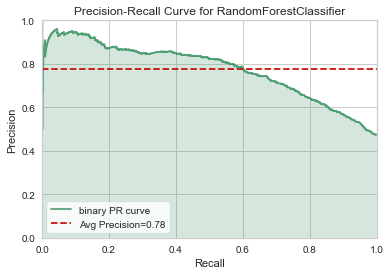

In [24]:
# using random forest results: precision recall curve
visualizer_pr = PrecisionRecallCurve(gs_rf_best)
visualizer_pr.fit(xtrain, ytrain)
visualizer_pr.score(xtest, ytest)
visualizer_pr.show()

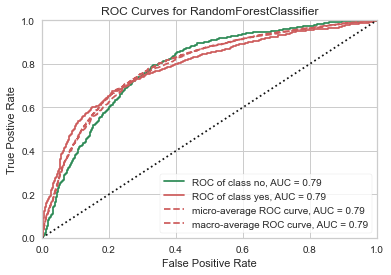

In [25]:
# using random forest results: ROC curve
visualizer_roc = ROCAUC(gs_rf_best, classes=["no", "yes"])
visualizer_roc.fit(xtrain, ytrain)
visualizer_roc.score(xtest, ytest)
visualizer_roc.show()

# 8 - Interpretability

**Let's check feature importances and some partial dependence plots using Random Forest (better accuracy until now)**

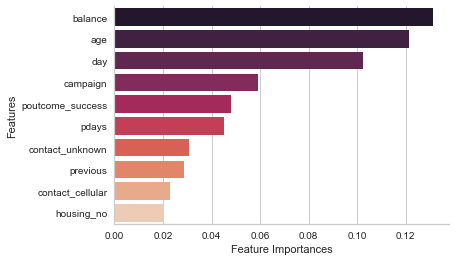

In [26]:
# using random forest here to get feature importances
importances= gs_rf_best.feature_importances_
feature_importances= pd.Series(importances, index=xtrain.columns).sort_values(ascending=False)
sns.barplot(x=feature_importances[0:10], y=feature_importances.index[0:10], palette="rocket")
sns.despine()
plt.xlabel("Feature Importances")
plt.ylabel("Features")
plt.show()

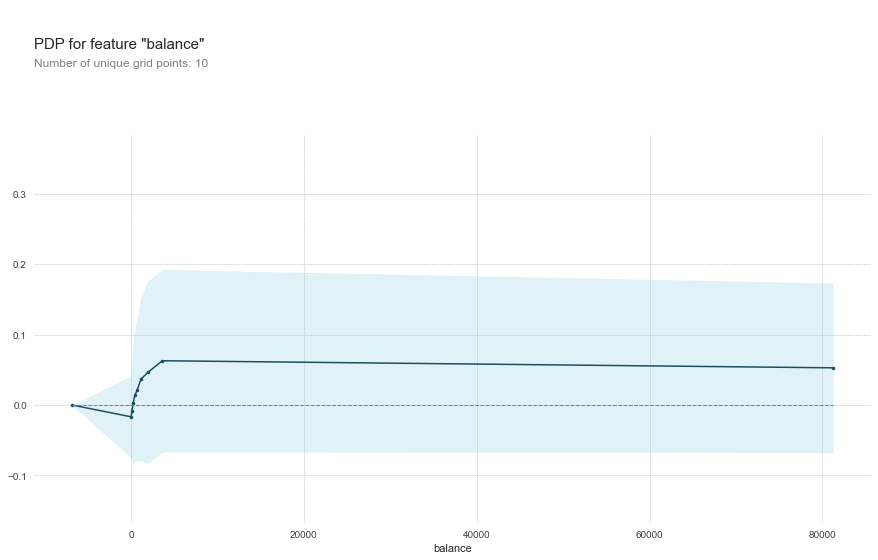

In [27]:
# partial dependence plot of balance
pdp_data=pdp.pdp_isolate(model=gs_rf_best, dataset=xtrain, model_features=xtrain.columns, feature='balance')
pdp.pdp_plot(pdp_data, 'balance')
plt.show()

**Here we can see that the increase on balance,up to a point, seems to increase the chances of acceptance (term deposit) .**

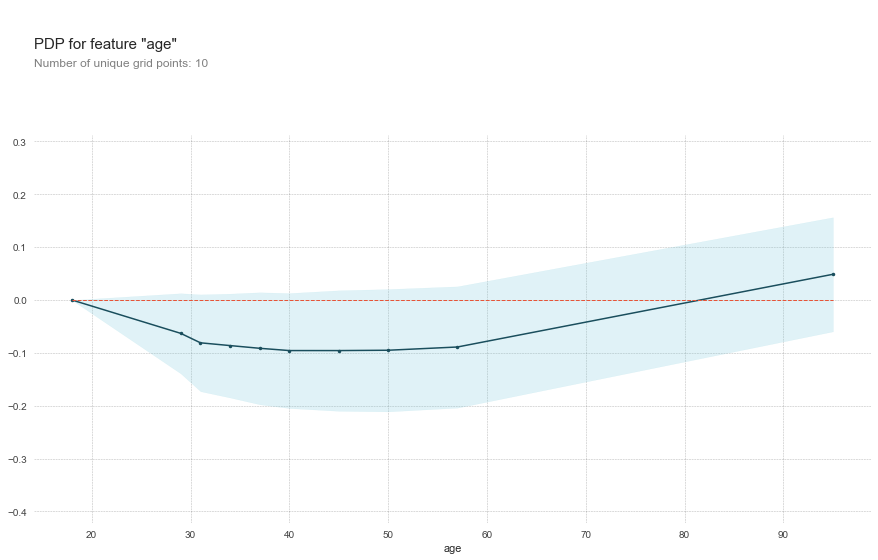

In [28]:
# partial dependence plot of age
pdp_data=pdp.pdp_isolate(model=gs_rf_best, dataset=xtrain, model_features=xtrain.columns, feature='age')
pdp.pdp_plot(pdp_data, 'age')
plt.show()

**Earlier ages seem to be related with less chance of acceptance until close to 50 years, then the age increase seems to increase the chances of acceptance.**

# 9 - More interpretability: SHAP

**SHAP is a method based on coalitional game theory, also know as cooperative game theory.**  
**SHAP method computes Shapley Values, basically speaking, a measure of how much a feature value of an observation contributes to the prediction (marginally and on average, across all positive coalitions).**  

**Lets make some plots based on this method:**  

1. Force plot shows feature values and its effects on prediction.
2. The summary plot shows feature importances and feature effects. The features are ordered by their importance and the points are Shapley Values representing the impact of features values on prediction.
3. The dependence plot shows the relationship between feature values and corresponding Shapley Values, in other words, feature values and their impact on prediction.


In [29]:
shap.initjs()

In [30]:
#high-speed exact algorithm for tree ensemble methods
explainer = shap.TreeExplainer(gs_xb_best)
shap_values = explainer.shap_values(xtrain)

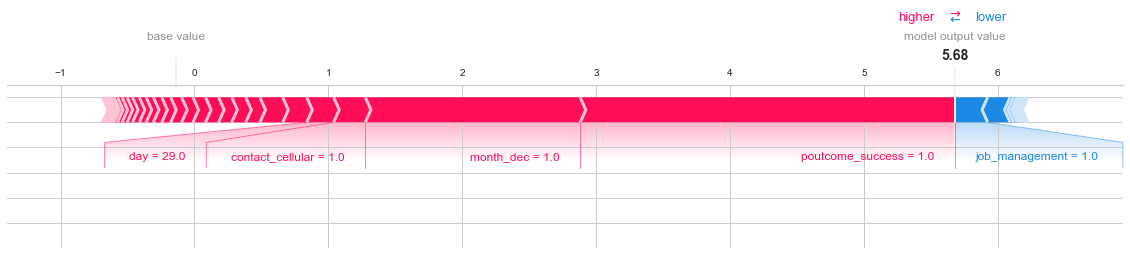

In [31]:
# first instance, feature values and its effects on prediction
shap.force_plot(explainer.expected_value, shap_values[0,:], xtrain.iloc[0,:],matplotlib=True)

In [32]:
# all instances, feature values and its effects on prediction
# shap.force_plot(explainer.expected_value, shap_values, xtrain)

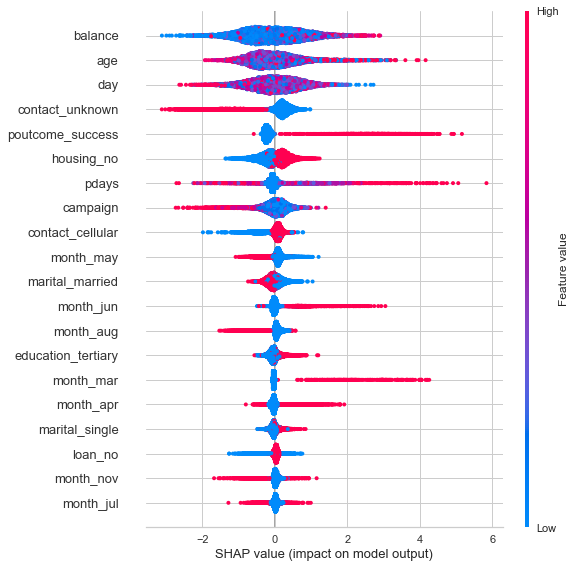

In [33]:
shap.summary_plot(shap_values, xtrain)

**Here we can see, for example, the positive effect of high values of age and high values of balance on the binary prediction. The dependence plots reinforce it.**

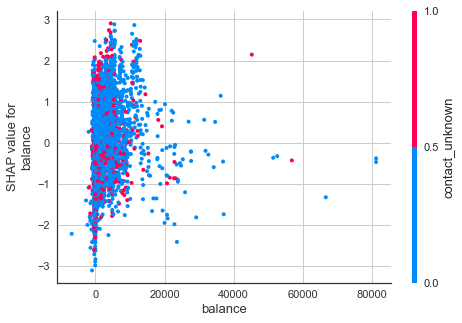

In [34]:
shap.dependence_plot("balance", shap_values, xtrain)

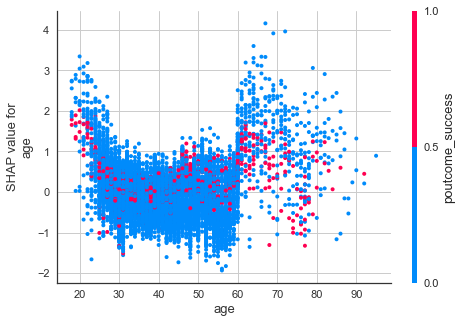

In [35]:
shap.dependence_plot("age", shap_values, xtrain)

# References:

1. Python Machine Learning: Machine Learning and Deep Learning with Python, scikit-learn, and TensorFlow from Sebastian Raschka e Vahid Mirjalili
2. Hands-On Machine Learning with Scikit-Learn and TensorFlow: Concepts, Tools, and Techniques to Build Intelligent Systems from Aurelien Geron
3. Interpretable Machine Learning, A Guide for Making Black Box Models Explainable by Christoph Molnar
4. https://www.scikit-yb.org/en/latest/